In [1]:
import pandas as pd
import os
from datetime import date, datetime
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
con = psycopg2.connect("dbname=predictordb host=localhost port=5432 user=postgres password=password")
cur = con.cursor()

In [3]:
sql1 = (
    "select * "
    "from predictions_results "
    "where (home_team = 'Chelsea' or away_team = 'Chelsea') "
    "order by match_date asc ")
df = pd.read_sql(sql1, con)
df[:8].to_clipboard(index=False)

In [ ]:
df = pd.read_sql(sql1, con)
df[:8].to_clipboard(index=False)

In [4]:
sql1 = (
    "select * "
    "from predictions_results "
    "where (home_team = 'West Ham United' or away_team = 'West Ham United') "
    "order by match_date asc ")
df = pd.read_sql(sql1, con)
df.head(8)
df[:8].to_clipboard(index=False)

In [5]:
teams_sql = ("with data as ( "
             "select distinct home_team team from predictions_results "
             "union all "
             "select distinct away_team team from predictions_results) "
             "select distinct team from data")
teams2 = pd.read_sql(teams_sql, con)
teams2.sort_values('team', ascending=True, ignore_index=True, inplace=True)
teams2

,team
0,AFC Bournemouth
1,Arsenal
2,Aston Villa
3,Brentford
4,Brighton & Hove Albion
5,Burnley
6,Cardiff City
7,Chelsea
8,Crystal Palace
9,Everton


In [6]:
full_df = []
for index, row in teams2.iterrows():
    sql = (
        "with data as ("
        "select match_date, '" + row['team'] + "' as Team, "
        "case when home_team = '" + row['team'] + "' then 'H' else 'A' end as H_or_A, fthg, ftag, ftr "
        "from predictions_results "
        "where (home_team = '" + row['team'] + "' or away_team = '" + row['team'] +"') "
        "order by match_date asc ),"
        "summary as (select match_date, Team, h_or_a, "
        "case when h_or_a = 'H' then fthg end home_goals, "
        "case when h_or_a = 'H' then ftag  end home_goals_concede, "
        "case when h_or_a = 'A' then ftag  end away_goals, "
        "case when h_or_a = 'A' then fthg  end away_goals_concede, "
        "case when h_or_a = 'A' and ftr = 'A' then 3 "
        "when h_or_a = 'H' and ftr = 'H' then 3 "
        "when h_or_a = 'H' and ftr = 'A' then 0 "
        "when h_or_a = 'A' and ftr = 'H' then 0 "
        "else 1 end points, "
        "ftr "
        "from data order by 1 desc), "
        "team as (select team, attack, midfield, defence, overall from predictions_team where team = '" + row['team'] + "' ) "
        "select s.match_date, t.team, "
        "avg(home_goals) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_h_goals_scored, "
        "avg(home_goals_concede) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_h_goals_concede, "
        "avg(away_goals) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_a_goals_scored, "
        "avg(away_goals_concede) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_a_goals_concede, "
        "avg(points) over (order by s.match_date asc rows between 6 preceding and 1 preceding) avg_points, "
        "t.attack, t.midfield, t.defence, t.overall "
        "from summary s "
        "join team t on s.team = t.team "
        "order by 1"
        
    )
    df = pd.read_sql(sql, con)
    full_df.append(df)

full_df = pd.concat(full_df)
full_df.head(30)
 

,match_date,team,avg_h_goals_scored,avg_h_goals_concede,avg_a_goals_scored,avg_a_goals_concede,avg_points,attack,midfield,defence,overall
0,2018-08-11,AFC Bournemouth,NaN,NaN,NaN,NaN,NaN,72,75,71,74
1,2018-08-18,AFC Bournemouth,2.000000,0.000000,NaN,NaN,3.000000,72,75,71,74
2,2018-08-25,AFC Bournemouth,2.000000,0.000000,2.0,1.0,3.000000,72,75,71,74
3,2018-09-01,AFC Bournemouth,2.000000,1.000000,2.0,1.0,2.333333,72,75,71,74
4,2018-09-15,AFC Bournemouth,2.000000,1.000000,1.0,1.5,1.750000,72,75,71,74
5,2018-09-22,AFC Bournemouth,2.666667,1.333333,1.0,1.5,2.000000,72,75,71,74
6,2018-10-01,AFC Bournemouth,2.666667,1.333333,0.666667,2.333333,1.666667,72,75,71,74
7,2018-10-06,AFC Bournemouth,2.666667,1.666667,0.666667,2.333333,1.666667,72,75,71,74
8,2018-10-20,AFC Bournemouth,2.666667,1.666667,1.333333,2.0,1.666667,72,75,71,74
9,2018-10-27,AFC Bournemouth,2.000000,1.000000,1.333333,2.0,1.666667,72,75,71,74


In [ ]:
#print(full_df['team'].unique())
full_df.fillna(0, inplace=True)
full_df.head()

In [ ]:
full_df.info()

In [ ]:
full_df.hist(figsize=(8,8), xrot=45)
plt.show()

In [ ]:
full_df.describe()

In [117]:
#distribution of goals
sql1 = (
    "select "
    "case when match_date <= '2019-05-12' then '18-19 season' "
    "     when match_date <= '2020-07-26' then '19-20 season' "
    "     when match_date <= '2021-05-16' then '20-21 season' "
    "else '21-22 season' end as season, "
    "'home' as home_away, sum(fthg) goals "
    "from predictions_results "
    "group by 1 "
    "union all "
    "select "
    "case when match_date <= '2019-05-12' then '18-19 season' "
    "     when match_date <= '2020-07-26' then '19-20 season' "
    "     when match_date <= '2021-05-16' then '20-21 season' "
    "else '21-22 season' end as season, "
    "'away', sum(ftag) home_goals "
    "from predictions_results "
    "group by 1 "

)
df = pd.read_sql(sql1, con)
df.head(8)
# d = sns.FacetGrid(df, col='season', col_order=['18-19 season','19-20 season','20-21 season','21-22 season'])
# d.map(plt.bar,'home_away', 'goals', )
# d.set_titles(col_template='{col_name}')
# plt.show()

,season,home_away,goals
0,20-21 season,home,482
1,18-19 season,home,596
2,19-20 season,home,576
3,21-22 season,home,71
4,20-21 season,away,483
5,18-19 season,away,476
6,19-20 season,away,458
7,21-22 season,away,47


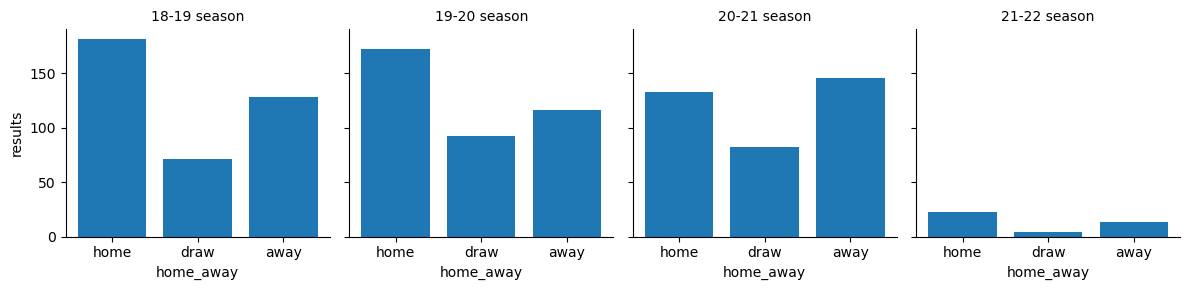

In [116]:
#distibution of home away victories


sql1 = (
    "select "
    "case when match_date <= '2019-05-12' then '18-19 season' "
    "     when match_date <= '2020-07-26' then '19-20 season' "
    "     when match_date <= '2021-05-16' then '20-21 season' "
    "else '21-22 season' end as season, "
    "'home' as home_away, "
    "sum(case when ftr = 'H' then 1 else 0 end ) results "
    "from predictions_results "
    "group by 1 "
    "union all "
        "select "
    "case when match_date <= '2019-05-12' then '18-19 season' "
    "     when match_date <= '2020-07-26' then '19-20 season' "
    "     when match_date <= '2021-05-16' then '20-21 season' "
    "else '21-22 season' end as season, "
    "'draw' as home_away, "
    "sum(case when ftr = 'D' then 1 else 0 end ) results "
    "from predictions_results "
    "group by 1 "
    "union all "
        "select "
    "case when match_date <= '2019-05-12' then '18-19 season' "
    "     when match_date <= '2020-07-26' then '19-20 season' "
    "     when match_date <= '2021-05-16' then '20-21 season' "
    "else '21-22 season' end as season, "
    "'away' as home_away, "
    "sum(case when ftr = 'A' then 1 else 0 end ) results "
    "from predictions_results "
    "group by 1 "
)
df = pd.read_sql(sql1, con)
d = sns.FacetGrid(df, col='season',  col_order=['18-19 season','19-20 season','20-21 season','21-22 season'])
d.map(plt.bar,'home_away', 'results', )
d.set_titles(col_template='{col_name}')
plt.show()

/Users/smarino/opt/anaconda3/envs/tf_predictor/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


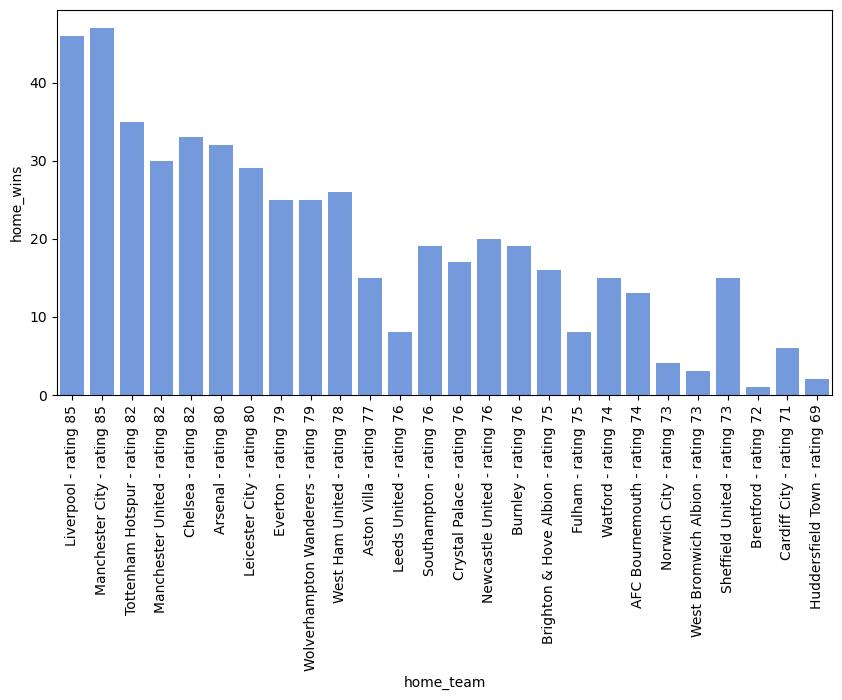

In [99]:
#distibution of home victories by ranking
fig, ax = plt.subplots(figsize=(10, 5))
sql1 = (
    "with data as (select home_team, sum(case when ftr = 'H' then 1 else 0 end) home_wins "
    "from predictions_results "
    "group by 1 "
    "order by 2 desc), "
    "rating as (select team, overall from predictions_team where league in ('Premier League','EFL Championship')) "
    "select home_team || ' - rating ' || overall home_team, home_wins from data d "
    "left join rating r on d.home_team = r.team "
    

)
df = pd.read_sql(sql1, con)
df.head(8)
g = sns.barplot('home_team', 'home_wins', data=df, color='cornflowerblue')

for label in g.get_xticklabels():
    label.set_rotation(90)
plt.show()

/Users/smarino/opt/anaconda3/envs/tf_predictor/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


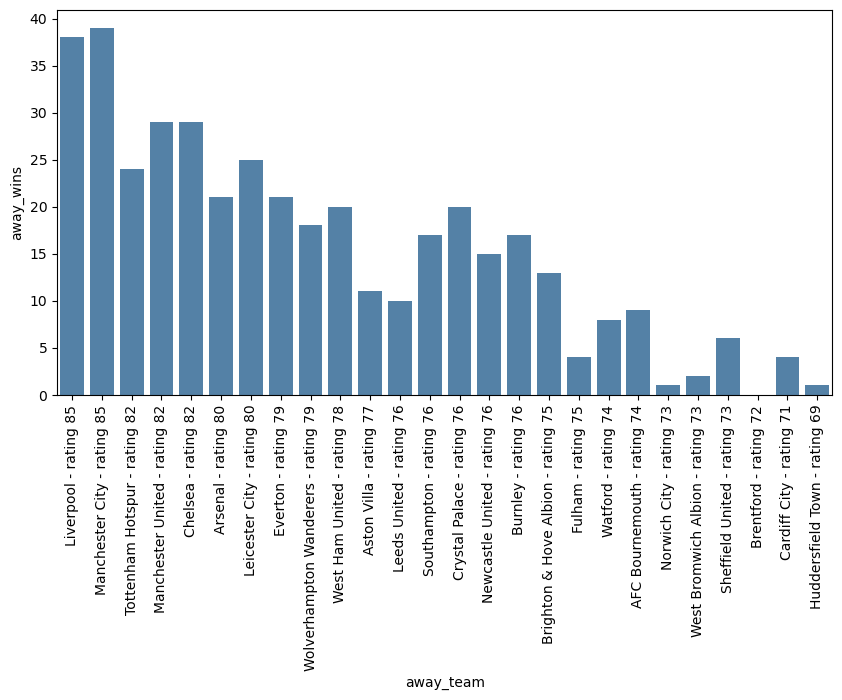

In [106]:
#distibution of away victories by ranking
fig, ax = plt.subplots(figsize=(10, 5))
sql1 = (
    "with data as (select away_team, sum(case when ftr = 'A' then 1 else 0 end) away_wins "
    "from predictions_results "
    "group by 1 "
    "order by 2 desc), "
    "rating as (select team, overall from predictions_team where league in ('Premier League','EFL Championship')) "
    "select away_team || ' - rating ' || overall away_team, away_wins from data d "
    "left join rating r on d.away_team = r.team "
    

)
df = pd.read_sql(sql1, con)
df.head(8)
g = sns.barplot('away_team', 'away_wins', data=df, color='steelblue')

for label in g.get_xticklabels():
    label.set_rotation(90)
plt.show()